┌ Warning: thread = 1 warning: only found 31 / 33 columns around data row: 11. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 31 / 33 columns around data row: 14. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 31 / 33 columns around data row: 19. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 31 / 33 columns around data row: 21. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 31 / 33 columns around data row: 22. Filling remaining columns with `missing`
└ @ CSV /Users/jimehrlich/.julia/packages/CSV/cHirL/src/file.jl:578
┌ Warning: thread = 1 warning: only found 31 / 33 columns ar

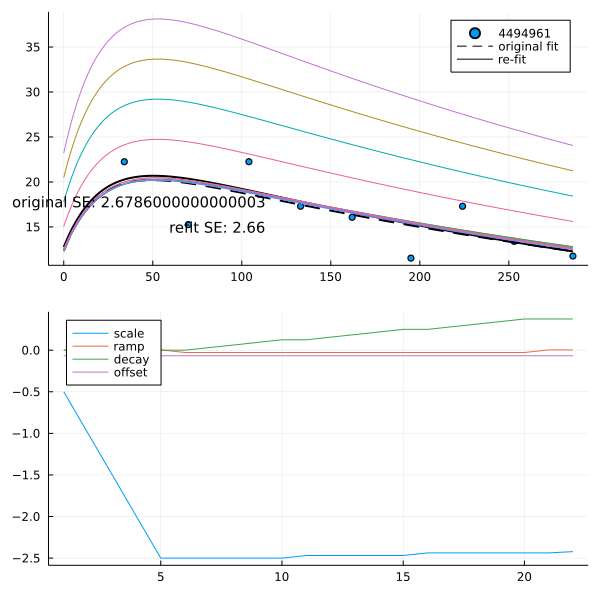

In [3]:
include("/Users/jimehrlich/IdeaProjects/MilkBot-API/utilities/julia/milkbot.jl")
using  .Milkbot, CSV, HTTP, StructTypes,  Plots, DataFrames, JSON3, TensorCast, Setfield

const authHeader = Dict("X-API-KEY"=>"<YOUR API KEY HERE")
#const lac =  """{"lactation": {"lacKey":"1","breed":"zebra","parity":2,"points":[{"dim":23,"milk":33,"dayFraction":1},{"dim":43,"milk":43,"dayFraction":1},{"dim":63,"milk":63,"dayFraction":1},{"dim":83,"milk":73,"dayFraction":1},{"dim":102,"milk":73,"dayFraction":1},{"dim":123,"milk":63,"dayFraction":1},{"dim":143,"milk":68,"dayFraction":1},{"dim":163,"milk":60,"dayFraction":1},{"dim":183,"milk":58,"dayFraction":1},{"dim":203,"milk":62,"dayFraction":1},{"dim":223,"milk":52,"dayFraction":1},{"dim":283,"milk":43,"dayFraction":1}]}}"""
#server = "http://localhost:8080"
server = "https://milkbot.com/"
#server = "https://europe-west1-numeric-analogy-337601.cloudfunctions.net/milkBot-fitter"
apikey = "test" 
cred = Credentials(server, apikey)

#pwd() #to get your current working directory
file = "julia/21024pM.csv"
const df = CSV.read(file,DataFrame, types = Dict(3=>String))
#println(sort(Dict(1:length(names(df)) .=> names(df))))


struct RowType1
    lactkey::Integer
    breed::String
    parity::Integer
    scale::Number
    ramp::Number 
    decay::Number
    offset::Number
    n::Integer
    se::Number
    dim::Vector
    milk::Vector
end

RowType1(d:: DataFrame, r::Integer ) = RowType1(
    d[r,:lactkey], 
    d[r,:Breed],      
    d[r,:Parity],
    d[r,:Scale]*.454, #convert to kg
    d[r,:Ramp],
    d[r,:Decay],
    d[r,:Offset],
    d[r,:points],
    d[r,:RMSE]*.454, #convert to kg,
    filter(!isnothing, map(n -> d[r, "dim$(n)"], 1:9)),
    filter(!isnothing, map(n ->  d[r, "milk$(n)"], 1:9)) 
)
StructTypes.StructType(::Type{Priors}) = StructTypes.Struct()
StructTypes.StructType(::Type{MBParams}) = StructTypes.Struct()
StructTypes.StructType(::Type{Fit}) = StructTypes.Struct()

pr = getPriorsTree(cred) #then cut out Hostein/Parity2/priors below 
jsp = JSON3.read(pr).content.node.priorsTree[1].content.node.priorsTree[2].content.node.priors 
h2priors = JSON3.read(JSON3.write(jsp), Priors) #no PriorsTree struct


#converts milk to Kg
lacFromRow(r::RowType1) = begin
    pts = map(i -> MilkPoint(r.dim[i], r.milk[i]*.454) , 1:(min(length(r.dim),length(r.milk))))
    l = Lactation(string(r.lactkey),r.breed,r.parity, pts)
    f = Fit(string(r.lactkey),  MBParams(r.scale,r.ramp,r.decay,r.offset), r.n, r.se, nothing) #no path yet
FittedLactation(l,f)
end

r = RowType1(df,35)
fl = lacFromRow(r)

reFit = JSON3.read(fitLactation(fl.lac, h2priors, cred), Fit) 

p = refitPlot(fl, h2priors, cred)
display(p)

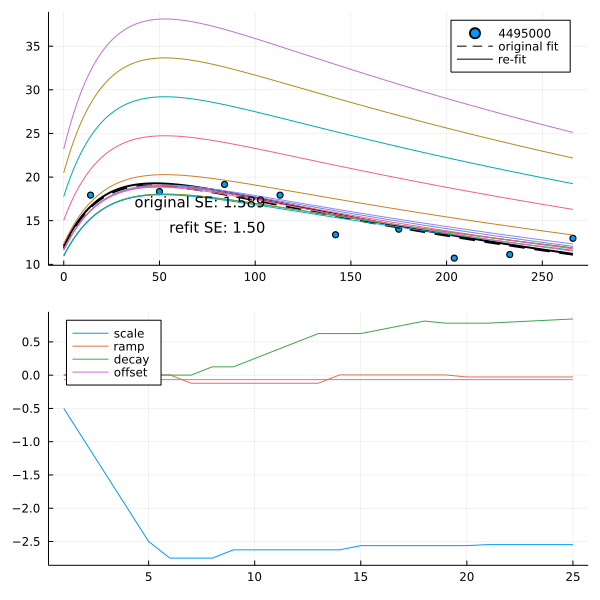

In [5]:
r = RowType1(df,3)
fl = lacFromRow(r)

reFit = JSON3.read(fitLactation(fl.lac, h2priors, cred), Fit) 

p = refitPlot(fl, h2priors, cred)
display(p)

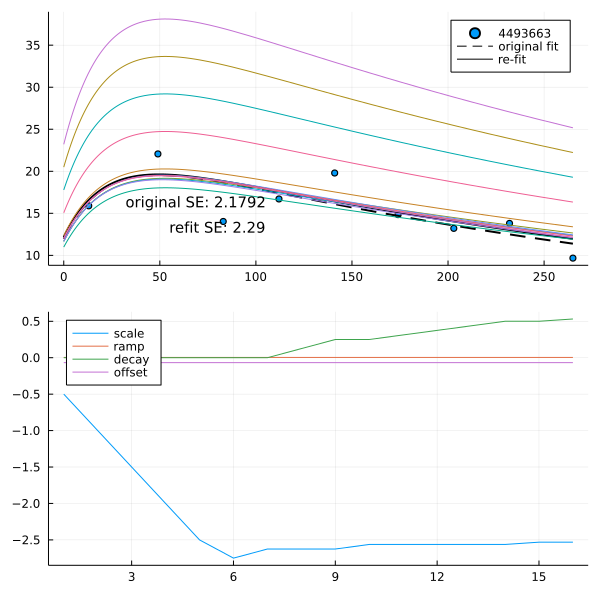

In [6]:
r = RowType1(df,4)
fl = lacFromRow(r)

reFit = JSON3.read(fitLactation(fl.lac, h2priors, cred), Fit) 

p = refitPlot(fl, h2priors, cred)
display(p)

In [7]:
h2priors.means

MBParams(Float16(50.16), Float16(22.75), Float16(0.002184), Float16(-0.7754))